In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from astropy.io import fits
from astropy.visualization import simple_norm

import ccdproc as ccdp

Filename: ../reduced_lights/pp_r01.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      28   (3840, 2160)   float64   
  1  MASK          1 ImageHDU         8   (3840, 2160)   uint8   
  2  UNCERT        1 ImageHDU         9   (3840, 2160)   float64   


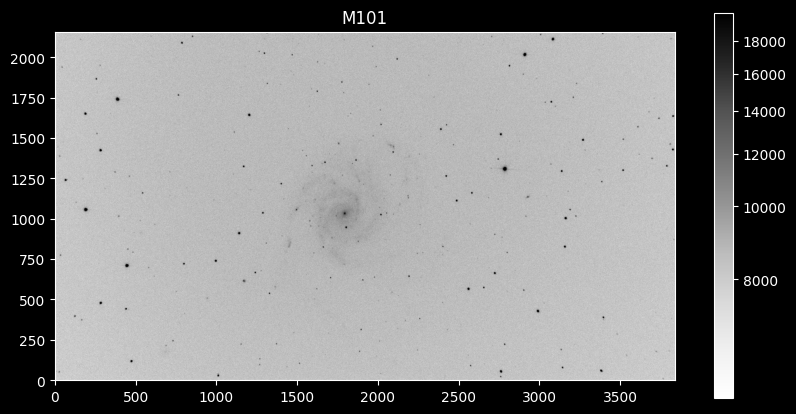

In [12]:
file_name = '../reduced_lights/pp_r01.fit'

hdul = fits.open(file_name)
hdul.info()

image_data = hdul[0].data * 65536
header = hdul[0].header
hdul.close()



norm = simple_norm(image_data, stretch='sqrt', percent=99.9)
plt.style.use('dark_background')
plt.figure(figsize=(10, 5))
plt.imshow(image_data, cmap='Greys', norm=norm, origin='lower')
plt.colorbar()
plt.title('M101')
plt.show()

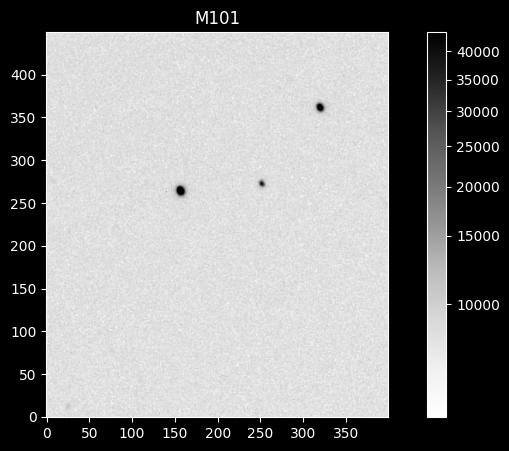

In [28]:
section1 = image_data[300:750, 2400:2800]

norm = simple_norm(section1, stretch='sqrt', percent=99.9)
plt.figure(figsize=(10, 5))
plt.imshow(section1, cmap='Greys', norm=norm, origin='lower')
plt.colorbar()
plt.title('M101')
plt.show()

In [29]:
from astropy.stats import sigma_clipped_stats

mean, median, std = sigma_clipped_stats(section1, sigma=3.0)

print(mean, median, std)

8545.735691628093 8541.540019444055 466.23778402989876


In [30]:
from photutils.detection import DAOStarFinder

daofind = DAOStarFinder(fwhm = 3.0, threshold = 5.0*std)

sources = daofind(section1-median)

for col in sources.colnames:
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'

sources.pprint(max_width = 100)

 id xcentroid ycentroid sharpness roundness1 roundness2 npix   peak      flux     mag   daofind_mag
--- --------- --------- --------- ---------- ---------- ---- -------- ---------- ------ -----------
  1      4.92     19.75      0.59       0.01      -0.34   25  1995.76    8259.10  -9.79       -0.03
  2    156.93    107.79      0.83      -0.78      -0.29   25  4571.80    6936.70  -9.60       -0.57
  3     22.27    156.27      0.55       0.59      -0.25   25  1921.23     175.16  -5.61       -0.00
  4    156.94    260.44      0.50      -0.11      -0.02   25 51164.97  934919.31 -14.93       -2.24
  5    155.36    265.75      0.50       0.97       0.08   25 56680.03  965509.98 -14.96       -2.41
  6    251.28    272.23      0.35      -0.38       0.18   25 34352.83  547822.63 -14.35       -2.28
  7    362.87    321.40      0.62      -0.18      -0.69   25  1863.19    -832.44    nan       -0.00
  8    319.53    360.59      0.41      -0.01      -0.07   25 56696.03 1014610.11 -15.02       -2.44


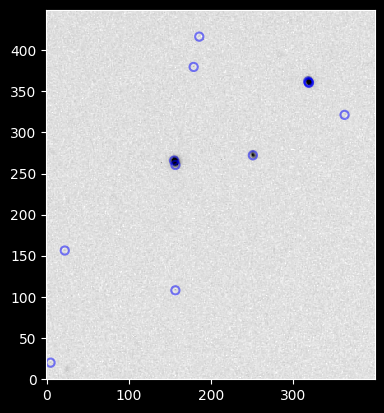

In [31]:
from photutils.aperture import CircularAperture

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

apertures = CircularAperture(positions, r = 5.0)

norm = simple_norm(section1, stretch='sqrt', percent=99.9)
plt.imshow(section1, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')

apertures.plot(color = 'blue', lw = 1.5, alpha = 0.5)
plt.show()

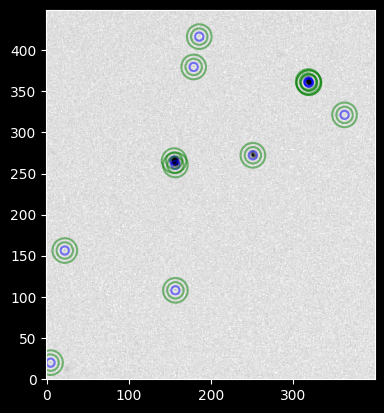

In [38]:
from photutils.aperture import CircularAnnulus, CircularAperture, ApertureStats, aperture_photometry

annulus_aperture = CircularAnnulus(positions, r_in = 10, r_out= 15)

plt.figure()
norm = simple_norm(section1, stretch='sqrt', percent=99.9)
plt.imshow(section1, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5)
annulus_aperture.plot(color='green', lw=1.5, alpha=0.5)
plt.show()

In [40]:
aperstats = ApertureStats(section1, annulus_aperture)
bkg_mean = aperstats.mean
aperture_area = apertures.area_overlap(section1)
total_bkg = bkg_mean * aperture_area

star_data = aperture_photometry(section1, apertures)

star_data['total_bkg'] = total_bkg

for col in star_data.colnames:
    star_data[col].info.format = '%.8g'

star_data.pprint()

 id  xcenter   ycenter  aperture_sum total_bkg
--- --------- --------- ------------ ---------
  1 4.9159323 19.746147    674116.06 669198.36
  2 156.92889 107.79264    680230.99 670362.36
  3 22.266529 156.26933     670572.9 672298.98
  4 156.94083 260.43775    3094491.4 721464.32
  5 155.35549 265.74517    3712576.9 712551.24
  6 251.27505  272.2279    1546680.7 672388.87
  7 362.87235 321.40484    680476.12 661895.18
  8 319.53225  360.5942    3190922.8 692051.85
  9 319.26128 360.70047    3206004.5 692523.03
 10 318.60073  362.1191    3183359.7 694850.96
 11  179.1659 379.77628     678251.2 673464.73
 12 185.97652 416.66922    665974.92  677013.6


In [42]:
extime = 180

import math

ZP = 13.85 + 2.5*math.log10(abs(1546680.7-672388.87)/extime)
print(f'zero point {ZP}')

zero point 23.06595978737463


In [43]:
extime = 180

import math
magnitudes = []

for line in star_data:
    magnitudes.append(ZP-(2.5*math.log10(abs(line[3]-line[4])/extime)))

star_data['magnitude'] = magnitudes
star_data.pprint(max_lines = -1, max_width = -1)

 id  xcenter   ycenter  aperture_sum total_bkg     magnitude     
--- --------- --------- ------------ --------- ------------------
  1 4.9159323 19.746147    674116.06 669198.36 19.474735103600857
  2 156.92889 107.79264    680230.99 670362.36  18.71849988980377
  3 22.266529 156.26933     670572.9 672298.98 20.611488428429478
  4 156.94083 260.43775    3094491.4 721464.32  12.76588430836104
  5 155.35549 265.74517    3712576.9 712551.24 12.511328616726082
  6 251.27505  272.2279    1546680.7 672388.87 13.849999954785023
  7 362.87235 321.40484    680476.12 661895.18 18.031471801839935
  8 319.53225  360.5942    3190922.8 692051.85 12.709781498491802
  9 319.26128 360.70047    3206004.5 692523.03 12.703451849214352
 10 318.60073  362.1191    3183359.7 694850.96 12.714293108284295
 11  179.1659 379.77628     678251.2 673464.73 19.504103091382163
 12 185.97652 416.66922    665974.92  677013.6 18.596848804321965
